In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [247]:
# Generating random graph
deep_reload(src)

# Seed for replication
seed = np.random.randint(0, sys.maxsize)
seed = 758712061200539789
# print(seed)

# Numbers of nodes origins, destinations, and chargers
n_nodes = 100
n_origins = 5
n_destinations = 1
n_chargers = 15

# Graph parameters
scale = (1000, 1000) # graph scale [km]
link_bounds = (1e-6, np.inf) # Link distance boundaries [km]
reference_distance = 100 # Characteristic distance for link probability function [km]
link_speeds = [105] # Possible values for link speeds [km/h]

# Number of cases for stochastic routing
n_cases = 10
n_intervals = 10

# Vehicle parameters
vehicle_range = 400
min_range = 0

# Driver parameters
risk_tolerance = .5

# Charger parameters
charge_rate = 200 # [km/h]
usability_rate = 1
max_delay = 1 # [h]
availability_rate = usability_rate
charge_price = .03 # [$/km]

# Graph generation
graph = src.rng.random_graph(
    n_nodes,
    scale = scale,
    reference_distance = reference_distance,
    link_bounds = link_bounds,
    link_speeds = link_speeds,
    seed = seed,
    range_multiplier = 1
)

# Origins and Destinations
origin_nodes, destination_nodes = src.rng.random_origin_destination(
    graph, n_origins, n_destinations, seed = seed)

# Adding cost objects to graph

# Chargers to add to charger nodes

charger = src.routing.Charger(
    lambda x: (x > usability_rate) * vehicle_range,
    lambda x: charge_rate,
    lambda x: (
        (x > availability_rate) *
        ((x-availability_rate) / (1 - availability_rate + 1e-6) * max_delay)
    ),
    lambda x: charge_price * (.9 + .2 * x),
    seed = seed,
)

# Adding to graph
graph, charger_nodes = src.rng.random_chargers(graph, n_chargers, charger, seed)

# Defining the problem objective
def super_quantile_2d(x, alpha, **kwargs):

    sq = np.empty((x.shape[0]))

    for idx in range(x.shape[0]):

        sq[idx] = src.utilities.super_quantile(x[idx], risk_tolerance)

    return sq

initial = np.linspace(0, vehicle_range, n_intervals)  

objectives = {
    'time': lambda x: super_quantile_2d(x['time'], risk_tolerance),
}

constraints = {
    'range': (
        lambda x: super_quantile_2d(x['range'], risk_tolerance) < initial
    ),
}

states = {
    'range': {
        'field': 'range',
        'initial': initial,
        'final': np.ones((n_intervals, n_cases)) * 0,
        'update': lambda x, v: x + v,
    },
    'time': {
        'field': 'time',
        'initial': np.zeros(n_cases),
        'final': np.ones((n_intervals, n_cases)) * 0,
        'update': lambda x, v: x + v,
    },
    'distance': {
        'field': 'distance',
        'initial': np.zeros(n_cases),
        'final': np.ones((n_intervals, n_cases)) * 0,
        'update': lambda x, v: x + v,
    },
    'price': {
        'field': 'price',
        'initial': np.zeros(n_cases),
        'final': np.ones((n_intervals, n_cases)) * 0,
        'update': lambda x, v: x + v,
    },
}

In [248]:
deep_reload(src)

t0 = time.time()
path_costs, path_values = src.routing.bellman_integration(
    graph, 
    destination_nodes,
    origins = [],
    states = states,
    constraints = constraints,
    objectives = objectives,
)
time.time() - t0

1.033513069152832

In [253]:
path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

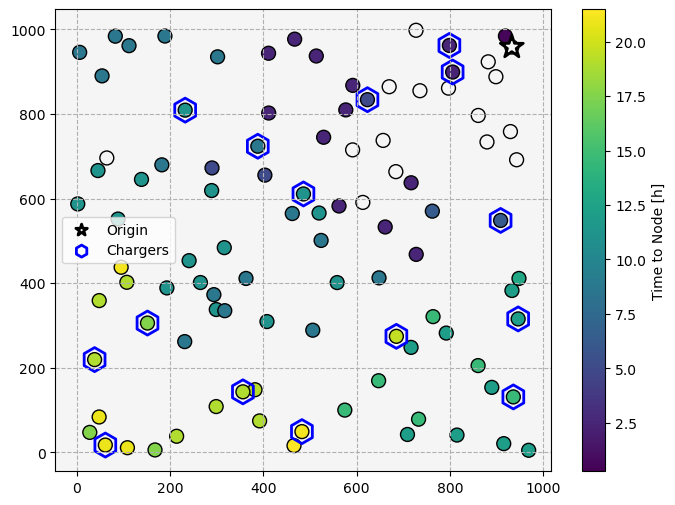

In [254]:
deep_reload(src)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, destination_nodes, [], charger_nodes, ax = ax,
    show_links = False)

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/parameter_factorial_11.png', bbox_inches = 'tight', dpi = 300)

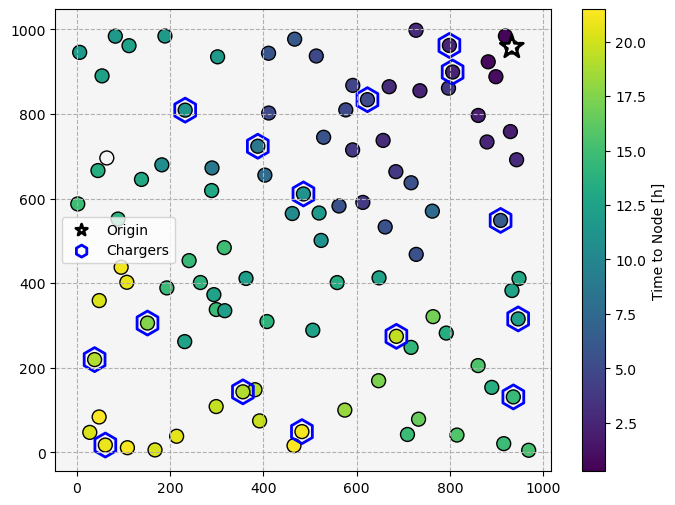

In [250]:
deep_reload(src)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, destination_nodes, [], charger_nodes, ax = ax,
    show_links = False)

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/parameter_factorial_11.png', bbox_inches = 'tight', dpi = 300)